In [1]:
# Model name as saved to gcs (it can be found in the model_name config key in wandb)
# wandb run: devoted-armadillo-46
MODEL_NAME = "20220525-132819_03_tacotron_8khz_overfit__TacotronTTS"
LOCAL_MODEL_DIR = 'copied_models'

In [2]:
# Access project root dir
import git
import os
root_dir = git.Repo('.', search_parent_directories=True).working_tree_dir

os.chdir(root_dir) # Ugly way to get access to imports but this way is also easier for ginconfig

In [3]:
%load_ext autoreload
%autoreload 2


from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython
import tensorflow as tf
import subprocess

import prepare_data
import training
import cloud_training
import utils
import models
import gin

gin.parse_config_file('config/cloud_gpu.gin')
gin.parse_config_file('config/experiments/03_tacotron_8khz_overfit.gin')
gin.enter_interactive_mode()

fft_length = gin.query_parameter('%fft_length')
frame_length = gin.query_parameter('%frame_length')
frame_step = gin.query_parameter('%frame_step')
sample_rate = gin.query_parameter('%sample_rate')

gsutil = os.path.dirname(gin.query_parameter('gcloud.gcloud_path')) + '/gsutil'
gcs_model_path = gin.query_parameter('gcloud_remote_training.gcs_model_path')

2022-05-27 12:38:34.846030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-27 12:38:34.846147: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [4]:
train_dataset, _ = prepare_data.datasets(target_sample_rate=sample_rate, keep_audio=True, keep_raw_spectrogram=True, keep_transcription=True)

batch = list(train_dataset.take(1))[0]
spectrogram, mel_spec, enc_transcription, audio, raw_spectrogram, transcription = (col[0].numpy() for col in batch)

2022-05-27 12:38:36.007616: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


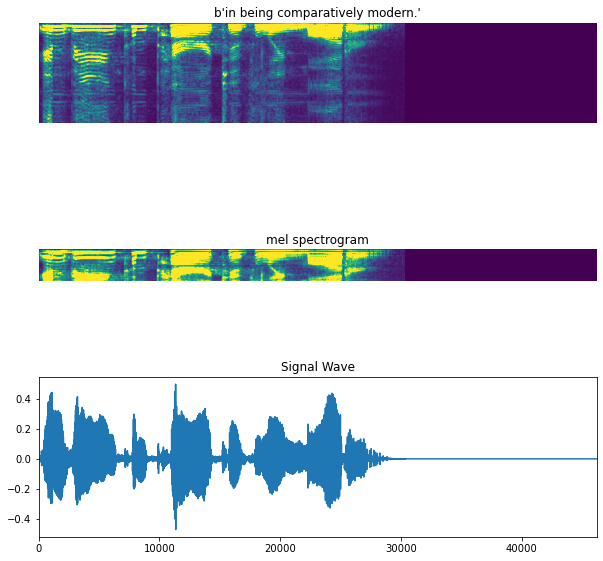

In [5]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 1, 1)
ax.imshow(np.transpose(spectrogram), vmax=1)
ax.set_title(transcription)
ax.axis("off")

ax = plt.subplot(3, 1, 2)
ax.imshow(np.transpose(mel_spec), vmax=1)
ax.set_title('mel spectrogram')
ax.axis("off")

ax = plt.subplot(3, 1, 3)
plt.plot(np.transpose(audio))
ax.set_title("Signal Wave")
ax.set_xlim(0, len(audio))
    
IPython.display.display(IPython.display.Audio(np.transpose(audio), rate=sample_rate))
plt.show()


In [6]:
# Download model and load it
cmd = [gsutil, '-m', 'cp', '-r', gcs_model_path + MODEL_NAME + '*', LOCAL_MODEL_DIR]
subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [6]:
tts = models.TacotronTTS()
tts.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME)

In [7]:
enc_transcription

array([ 9, 14, 30,  2,  5,  9, 14,  7, 30,  3, 15, 13, 16,  1, 18,  1, 20,
        9, 22,  5, 12, 25, 30, 13, 15,  4,  5, 18, 14,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [8]:
input = tf.expand_dims(enc_transcription[enc_transcription!=0], 0)

In [9]:
GEN_FRAMES = 600

In [10]:
new_mel_spec = tts.decode(input, GEN_FRAMES)

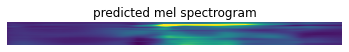

In [11]:
ax = plt.subplot(1, 1, 1)
ax.imshow(np.transpose(new_mel_spec[0]), vmax=1)
ax.set_title('predicted mel spectrogram')
ax.axis("off")
plt.show()

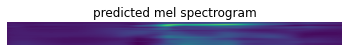

In [12]:
ax = plt.subplot(1, 1, 1)
ax.imshow(np.transpose(new_mel_spec[0]))
ax.set_title('predicted mel spectrogram')
ax.axis("off")
plt.show()

In [13]:
pd.DataFrame({'mel_spec': mel_spec[:GEN_FRAMES,:].flatten(), 'predicted_mel_spec': new_mel_spec[0].numpy().flatten()}).describe()

,mel_spec,predicted_mel_spec
count,24000.000000,24000.000000
mean,0.516777,0.196312
std,0.527056,0.220869
min,0.000000,-0.086207
25%,0.098989,0.057392
50%,0.375960,0.123681
75%,0.765602,0.271670
max,3.915968,1.879203


In [14]:
# Let's investigate the output of the encoder
encoded = tts.tacotron_encoder(input)
input.shape, encoded.shape

(TensorShape([1, 29]), TensorShape([1, 29, 64]))

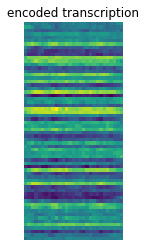

In [15]:
# when one removes normalization one sees nothing
# the magnitudes are very small

ax = plt.subplot(1, 1, 1)
ax.imshow(np.transpose(encoded[0]))
ax.set_title('encoded transcription')
ax.axis("off")
plt.show()

In [16]:
# Let's have a look at the embeddings
embed = tts.tacotron_encoder.embeddings(input)
pre_net = tts.tacotron_encoder.pre_net(embed)
embed.shape, pre_net.shape

(TensorShape([1, 29, 128]), TensorShape([1, 29, 64]))

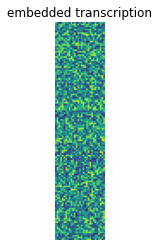

In [17]:
ax = plt.subplot(1, 1, 1)
ax.imshow(np.transpose(embed[0]))
ax.set_title('embedded transcription')
ax.axis("off")
plt.show()

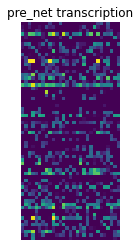

In [18]:
ax = plt.subplot(1, 1, 1)
ax.imshow(np.transpose(pre_net[0]))
ax.set_title('pre_net transcription')
ax.axis("off")

plt.show()

In [19]:
# With a random model
random_tts = models.TacotronTTS()
random_new_mel_spec = random_tts.decode(input, 600)

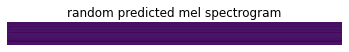

In [20]:
ax = plt.subplot(1, 1, 1)
ax.imshow(np.transpose(random_new_mel_spec[0]), vmax=1)
ax.set_title('random predicted mel spectrogram')
ax.axis("off")
plt.show()

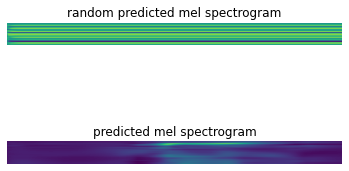

In [21]:
ax = plt.subplot(2, 1, 1)
ax.imshow(np.transpose(random_new_mel_spec[0]))
ax.set_title('random predicted mel spectrogram')
ax.axis("off")

ax = plt.subplot(2, 1, 2)
ax.imshow(np.transpose(new_mel_spec[0]))
ax.set_title('predicted mel spectrogram')
ax.axis("off")

plt.show()

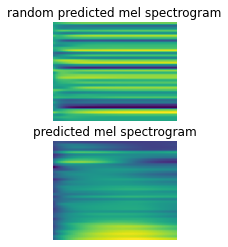

In [22]:
ax = plt.subplot(2, 1, 1)
ax.imshow(np.transpose(random_new_mel_spec[0, :50, :]))
ax.set_title('random predicted mel spectrogram')
ax.axis("off")

ax = plt.subplot(2, 1, 2)
ax.imshow(np.transpose(new_mel_spec[0, :50, :]))
ax.set_title('predicted mel spectrogram')
ax.axis("off")

plt.show()

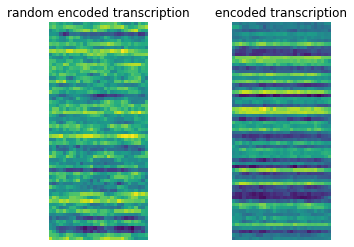

In [23]:
# Let's investigate the output of the random encoder
random_encoded = random_tts.tacotron_encoder(input)

ax = plt.subplot(1, 2, 1)
ax.imshow(np.transpose(random_encoded[0]))
ax.set_title('random encoded transcription')
ax.axis("off")

ax = plt.subplot(1, 2, 2)
ax.imshow(np.transpose(encoded[0]))
ax.set_title('encoded transcription')
ax.axis("off")

plt.show()

# Attention State Visualization

In [97]:
def visualize_attention_states(att_rnn_states):
    data = tf.concat([s[0] for s in att_rnn_states], 0)

    plt.figure(figsize=(10, 8))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('cell states')
    ax.axis("off")
    plt.show()
    
    data = tf.concat([s[1] for s in att_rnn_states], 0)

    plt.figure(figsize=(10, 8))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('attention')
    ax.axis("off")
    plt.show()
    
    data = tf.concat([s[2] for s in att_rnn_states], 0)

    plt.figure(figsize=(16, 14))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('attention state (alignments)')
    ax.axis("off")
    plt.show()

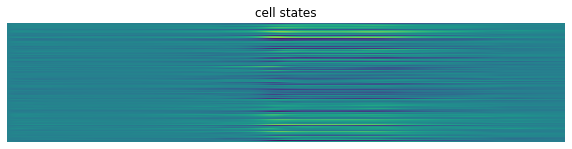

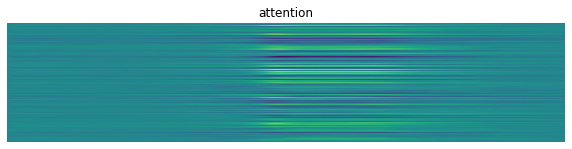

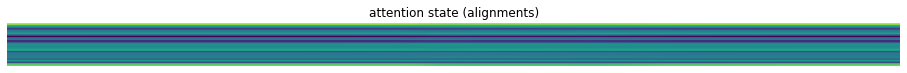

In [98]:
# TRAINED TTS
_, states = tts.decode(input, GEN_FRAMES, return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

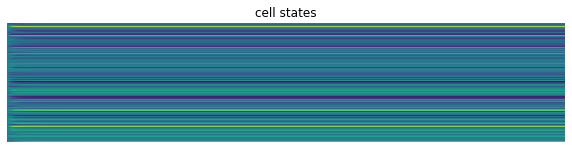

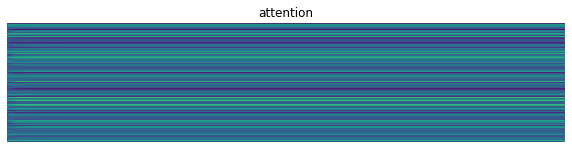

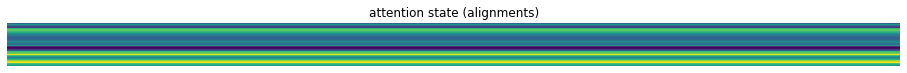

In [99]:
# RANDOM TTS
_, states = random_tts.decode(input, GEN_FRAMES, return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

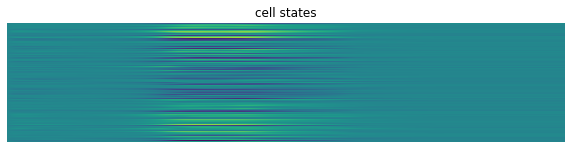

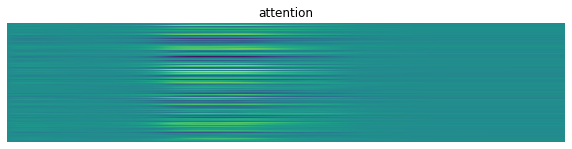

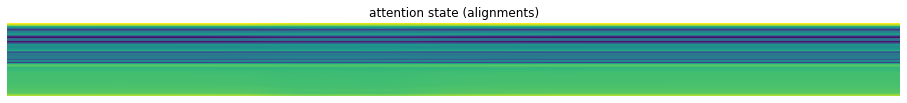

In [100]:
# TRAINED TTS WITH PADDING
_, states = tts.decode(tf.expand_dims(enc_transcription, 0), GEN_FRAMES, return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

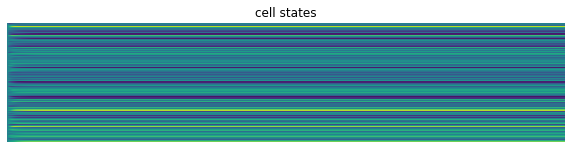

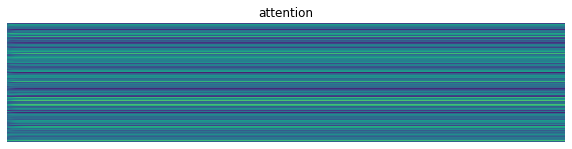

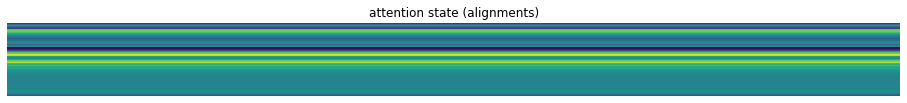

In [101]:
# RANDOM TTS WITH PADDING
_, states = random_tts.decode(tf.expand_dims(enc_transcription, 0), GEN_FRAMES, return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

It is clear that padding is influencing the output of the decoder (see attention state for padded part), so obviously masking needs to be added.

A question is how come the attention changes over time following the cell state even though the attention weights are almost not changing at all.

One possibility is that the cell output is being combined with the attention and hence causing the change. However we see in the code that if no attention_layer is specified, attention is just the dot product between memory and the attention weights https://github.com/tensorflow/addons/blob/master/tensorflow_addons/seq2seq/attention_wrapper.py.

We can see specifically using the dot product as the attention here: https://github.com/tensorflow/addons/blob/master/tensorflow_addons/seq2seq/attention_wrapper.py#L1560

Before trying to reproduce this result by running the dot product manually, let's have a look at the attention code. OK by instrumenting (prints), it turns out the branch that combined attention with the cell output in `_compute_attention` taken. This explains why the attention value in the state changes together with the cell output.

Ok, my bad, by providing `attention_layer_size` I told `AttentionWrapper` to create the dense layers that are used to combine attention and the RNN cell output.
